# Analysis of children's health data from Kolding

In [1]:
import gzip
import matplotlib
import matplotlib.pyplot as plt
import pandas
import seaborn
import xml.etree.ElementTree as ET

In [2]:
%matplotlib inline

## Load data into a pandas DataFrame

In [3]:
boern_xml = 'Boern.xml.gz'
with gzip.open(boern_xml) as fin:
    tree = ET.parse(fin)
    root = tree.getroot()
    child_data = []
    for child in root:
        #print(child.tag, child.attrib)
        child_attrib_list = [0] * 7
        for i, child_attrib in enumerate(child):
            #print(child_attrib.tag, child_attrib.text)
            child_attrib_list[i] = child_attrib.text
        child_data.append(child_attrib_list)

col_names = ['Child', 'Year', 'Gender', 'District', 'Weight', 'Height', 'Head Circumference']
child_df = pandas.DataFrame(child_data, columns=col_names)

In [4]:
numeric_cols = ['Child', 'Year', 'Weight', 'Height', 'Head Circumference']
child_df[[*numeric_cols]] = child_df[[*numeric_cols]].apply(pandas.to_numeric)

In [5]:
print('Read {:d} entries for {:d} children.'.format(len(child_df), len(child_df['Child'].unique())))

Read 116242 entries for 26125 children.


## Calculate children's age at each measurment

Note that first measurment for each child is taken at birth (age 0).
As a further data cleaning step, keep only the measurement with the largest height for each child in case multiple
measurements have been recorded within the same year.

In [6]:
child_grouped = child_df.groupby('Child')

child_age_dfs = []
for child_id, child_data in child_grouped:
    #print(child_id)
    min_year = child_data['Year'].min()
    child_data = pandas.concat([child_data, child_data['Year'] - min_year], axis=1)
    child_data.columns = col_names + ['Age']
    #print(child_data)

    child_data_cleaned_list = []
    for a, d in child_data.groupby('Age'):
        if len(d.shape) > 1:
            curr_cleaned = d.loc[d['Height'].argmax(), ]
        else:
            curr_cleaned = d
        child_data_cleaned_list.append(curr_cleaned)
    child_data_cleaned = pandas.concat(child_data_cleaned_list, axis=1)
    child_age_dfs.append(child_data_cleaned.transpose())

In [7]:
child_age_df = pandas.concat(child_age_dfs)

In [8]:
print('{:d} entries for {:d} children left.'.format(len(child_age_df), len(child_age_df['Child'].unique())))

52701 entries for 26125 children left.


### Example: Number of measurements per age group

All measurements for children younger than 2 have been removed in plot below.

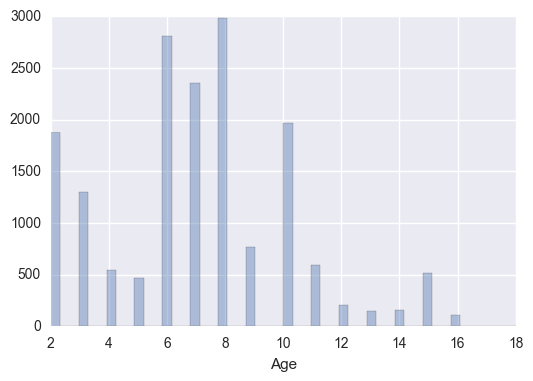

In [9]:
age_vec = child_age_df['Age']
age_vec_gt_1 = age_vec[age_vec > 1]
seaborn.distplot(age_vec_gt_1, kde=False)

## Export cleaned data to CSV

In [10]:
child_age_df.to_csv('children.csv')